# Stochastic Gradient Descent by Epoch

**Importing Libraries**

In [26]:
from SGD_by_Epoch import shuffle_data, sgd_by_epoch_process
from multiprocessing import Pool
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

**Importing Data**

In [15]:
dataframe = pd.read_excel('dataset1/dataset1.xlsx')

X = dataframe['V'].sort_values()
X = (X-X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y-y.mean()) / y.std()

X = np.reshape(X.values, (-1,1))

**Defining Useful Functions**

In [16]:
def polynomial_basis_function_transformation(X, h):
    """
    Converts an (N * 1) matrix into a (N * h) matrix, where h is the number of basis functions.
    The degree of the polynomial is (h-1).

    Parameters:
    - X: (N * 1) matrix of input features.
    - h: Number of basis functions (degree + 1).

    Returns:
    - X_poly: (N * h) matrix after applying polynomial basis functions.
    """
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly

### Methodology

I will attempt to implement parallelization of SGD based on the Santos et al paper.

**Procedure**

- Shuffle the data once for each process

- Carry out SGD independently for each process by going through shuffled list

- Average results of all processes after each epoch

In [28]:
def sgd_by_epoch(X, y, h, alpha, n, t):
    """
    Conducts Linear Regression using SGD with parallelization by epoch.
    """
    start = datetime.now()
    X_poly = polynomial_basis_function_transformation(X, h)
    epoch_size = len(X_poly)
    full_epochs = n // epoch_size

    # Initialize shared weights for the first epoch
    shared_weights = np.random.rand(h)

    # Parallelize shuffling
    with Pool(processes=t) as pool:
        shuffled_data = pool.starmap(shuffle_data, [(X_poly, y) for _ in range(t)])

    mse_history = []  # Track MSE for each epoch

    for epoch in range(full_epochs):
        epoch_start = datetime.now()

        with Pool(processes=t) as pool:
            outputs = pool.starmap(
                sgd_by_epoch_process,
                [(shuffled_data[i][0], shuffled_data[i][1], h, alpha, shared_weights) for i in range(t)]
            )

        shared_weights = np.mean(outputs, axis=0)

        # Calculate MSE for the current epoch
        y_hat_poly = X_poly @ shared_weights
        mse = mean_squared_error(y, y_hat_poly)
        mse_history.append(mse)

        epoch_end = datetime.now()

        print(f"Epoch {epoch + 1}/{full_epochs}, MSE: {mse}, Time for Epoch: {epoch_end - epoch_start}")

    final_beta_hat = shared_weights
    total_end = datetime.now()
    print(f"Total Time for Training: {total_end - start}")

    return mse_history

def plot_mse_vs_epochs(X, y, h, alpha, n):
    t_values = [1, 2, 3, 4, 8]  # List of `t` values
    plt.figure(figsize=(10, 6))

    for t in t_values:
        mse_history = sgd_by_epoch(X, y, h, alpha, n, t)
        plt.plot(range(1, len(mse_history) + 1), mse_history, label=f't={t}')

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs Epochs for Different Number of Processes')
    
    # Set log scale for MSE (y-axis)
    plt.yscale('log')

    # Adding grid and legend
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(1, len(mse_history) + 1, 1))  # Ensure x-axis is integer and includes all epochs
    plt.show()

Epoch 1/20, MSE: 0.2756592954052045, Time for Epoch: 0:00:00.509096
Epoch 2/20, MSE: 0.27296417343472645, Time for Epoch: 0:00:00.555236
Epoch 3/20, MSE: 0.2728343437151638, Time for Epoch: 0:00:00.492403
Epoch 4/20, MSE: 0.2728248976211442, Time for Epoch: 0:00:00.489231
Epoch 5/20, MSE: 0.272823937212169, Time for Epoch: 0:00:00.488992
Epoch 6/20, MSE: 0.27282379104252236, Time for Epoch: 0:00:00.485778
Epoch 7/20, MSE: 0.2728237606003873, Time for Epoch: 0:00:00.486664
Epoch 8/20, MSE: 0.2728237532713468, Time for Epoch: 0:00:00.486639
Epoch 9/20, MSE: 0.27282375141571247, Time for Epoch: 0:00:00.489818
Epoch 10/20, MSE: 0.27282375093824585, Time for Epoch: 0:00:00.490188
Epoch 11/20, MSE: 0.2728237508147441, Time for Epoch: 0:00:00.485747
Epoch 12/20, MSE: 0.2728237507827416, Time for Epoch: 0:00:00.487092
Epoch 13/20, MSE: 0.2728237507744435, Time for Epoch: 0:00:00.488250
Epoch 14/20, MSE: 0.2728237507722913, Time for Epoch: 0:00:00.486717
Epoch 15/20, MSE: 0.27282375077173304, T

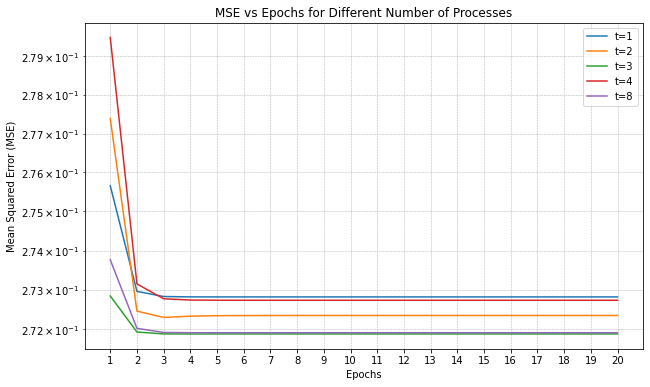

In [29]:
plot_mse_vs_epochs(X, y, 4, 0.001, 200000)

##### A dynamic learning rate was added to improve convergence during training. Starting with a larger learning rate helped the model learn quickly in the early stages, while gradually reducing it over epochs ensured more stable and precise convergence, preventing overshooting. This adjustment made the model more accurate and consistent as training progressed.

Starting SGD with t=1
Epoch 1/20, MSE: 0.2732833350626835, Time for Epoch: 0:00:01.261207
Epoch 2/20, MSE: 0.272805668212397, Time for Epoch: 0:00:00.994138
Epoch 3/20, MSE: 0.2726313293642604, Time for Epoch: 0:00:00.996035
Epoch 4/20, MSE: 0.2725164959031075, Time for Epoch: 0:00:01.118842
Epoch 5/20, MSE: 0.2724279024194409, Time for Epoch: 0:00:00.987371
Epoch 6/20, MSE: 0.27235605282782716, Time for Epoch: 0:00:01.064808
Epoch 7/20, MSE: 0.2722965667042812, Time for Epoch: 0:00:01.093831
Epoch 8/20, MSE: 0.2722467709829515, Time for Epoch: 0:00:01.062007
Epoch 9/20, MSE: 0.27220478513750945, Time for Epoch: 0:00:01.110781
Epoch 10/20, MSE: 0.2721691887706401, Time for Epoch: 0:00:01.008369
Epoch 11/20, MSE: 0.2721388676400097, Time for Epoch: 0:00:01.007693
Epoch 12/20, MSE: 0.2721129282387167, Time for Epoch: 0:00:00.999828
Epoch 13/20, MSE: 0.27209064413224887, Time for Epoch: 0:00:01.000435
Epoch 14/20, MSE: 0.2720714193118586, Time for Epoch: 0:00:01.034080
Epoch 15/20, MSE: 0

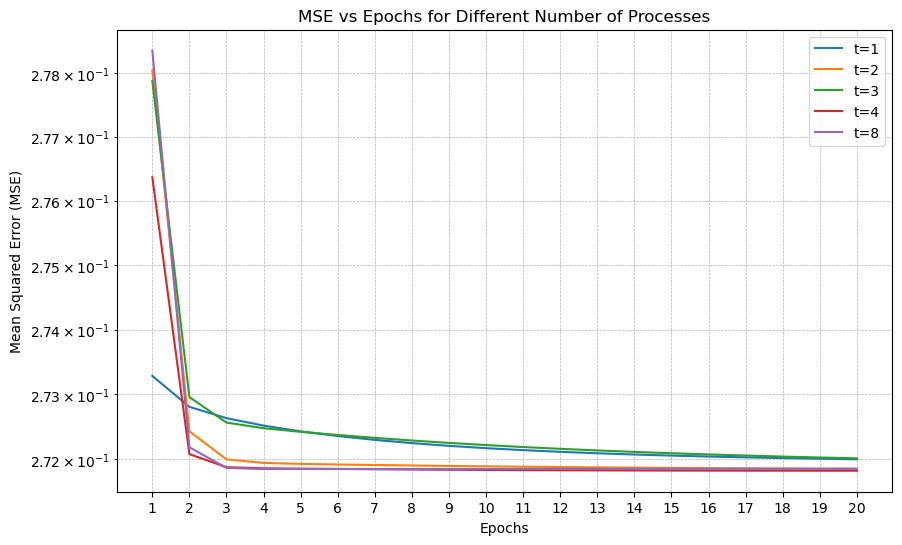

In [1]:
# Updated Code for SGD by Epoch with Debugging and Improved Plotting

from SGD_by_Epoch import shuffle_data, sgd_by_epoch_process
from multiprocessing import Pool
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Loading the dataset
dataframe = pd.read_excel('dataset1.xlsx')

X = dataframe['V'].sort_values()
X = (X - X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y - y.mean()) / y.std()

X = np.reshape(X.values, (-1, 1))


# Defining Utility Functions
def polynomial_basis_function_transformation(X, h):
    """
    Converts an (N * 1) matrix into a (N * h) matrix, where h is the number of basis functions.
    The degree of the polynomial is (h-1).

    Parameters:
    - X: (N * 1) matrix of input features.
    - h: Number of basis functions (degree + 1).

    Returns:
    - X_poly: (N * h) matrix after applying polynomial basis functions.
    """
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly


def sgd_by_epoch(X, y, h, b_alpha, n, t):
    """
    Conducts Linear Regression using SGD with parallelization by epoch.
    """
    start = datetime.now()
    X_poly = polynomial_basis_function_transformation(X, h)
    epoch_size = len(X_poly)
    full_epochs = n // epoch_size

    # Initialize shared weights for the first epoch
    shared_weights = np.random.rand(h)

    # Parallelize shuffling
    with Pool(processes=t) as pool:
        shuffled_data = pool.starmap(shuffle_data, [(X_poly, y) for _ in range(t)])

    mse_history = []  # Track MSE for each epoch
    
    """
    To improve the stability and convergence of the training process, 
    implemented a dynamic learning rate mechanism. 
    This adjustment allowed the learning rate to adapt progressively during training, 
    ensuring continuous convergence of the epochs.
    """
    for epoch in range(full_epochs):
        alpha = dynamic_learning_rate(epoch, b_alpha)
        epoch_start = datetime.now()

        with Pool(processes=t) as pool:
            outputs = pool.starmap(
                sgd_by_epoch_process,
                [(shuffled_data[i][0], shuffled_data[i][1], h, alpha, shared_weights) for i in range(t)]
            )

        shared_weights = np.mean(outputs, axis=0)

        # Calculate MSE for the current epoch
        y_hat_poly = X_poly @ shared_weights
        mse = mean_squared_error(y, y_hat_poly)
        mse_history.append(mse)

        epoch_end = datetime.now()

        print(f"Epoch {epoch + 1}/{full_epochs}, MSE: {mse}, Time for Epoch: {epoch_end - epoch_start}")

    final_beta_hat = shared_weights
    total_end = datetime.now()
    print(f"Total Time for Training: {total_end - start}")

    return mse_history

# Adding function for dynamic learning rate
def dynamic_learning_rate(epoch, base_alpha, decay_rate=0.1):
    return base_alpha / (1 + decay_rate * epoch)

# Plotting Function with Debugging
def plot_mse_vs_epochs(X, y, h, alpha, n):
    t_values = [1, 2, 3, 4, 8]  # List of `t` values
    plt.figure(figsize=(10, 6))

    for t in t_values:
        print(f"Starting SGD with t={t}")
        mse_history = sgd_by_epoch(X, y, h, alpha, n, t)
        print(f"MSE history for t={t}: {mse_history}")  # Debug statement
        if mse_history:  # Ensure there's data to plot
            plt.plot(range(1, len(mse_history) + 1), mse_history, label=f't={t}')
        else:
            print(f"No data to plot for t={t}")

    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs Epochs for Different Number of Processes')

    # Set log scale for MSE (y-axis)
    plt.yscale('log')

    # Adding grid and legend
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(1, len(mse_history) + 1, 1))  # Ensure x-axis is integer and includes all epochs
    plt.show()


# Running the Plotting Function
plot_mse_vs_epochs(X, y, 4, 0.001, 200000)

##### By increasing the number of iterations (n), the effect on MSE and computation time was analyzed. For fewer iterations, the MSE values across threads showed wider gaps, indicating less consistent convergence. However, with more iterations, convergence became more uniform, though computations were heavier. After balancing these factors, 200,000 to 300,000 iterations were identified as optimal, offering a good trade-off between computational efficiency and a well-converged MSE graph.

Starting SGD with t=1
Epoch 1/31, MSE: 0.27264050375893045, Time for Epoch: 0:00:00.926464
Epoch 2/31, MSE: 0.27248364073593845, Time for Epoch: 0:00:00.985743
Epoch 3/31, MSE: 0.2724404635334135, Time for Epoch: 0:00:00.940627
Epoch 4/31, MSE: 0.2724076801370541, Time for Epoch: 0:00:01.095740
Epoch 5/31, MSE: 0.2723779367716911, Time for Epoch: 0:00:01.148002
Epoch 6/31, MSE: 0.27234995520876054, Time for Epoch: 0:00:01.174981
Epoch 7/31, MSE: 0.27232328728642946, Time for Epoch: 0:00:01.014955
Epoch 8/31, MSE: 0.2722977139190158, Time for Epoch: 0:00:01.049948
Epoch 9/31, MSE: 0.272273125051938, Time for Epoch: 0:00:01.030371
Epoch 10/31, MSE: 0.2722494727910519, Time for Epoch: 0:00:00.922629
Epoch 11/31, MSE: 0.27222674391719387, Time for Epoch: 0:00:01.037044
Epoch 12/31, MSE: 0.27220494207845825, Time for Epoch: 0:00:00.946716
Epoch 13/31, MSE: 0.27218407643527537, Time for Epoch: 0:00:01.022191
Epoch 14/31, MSE: 0.2721641548270495, Time for Epoch: 0:00:01.077379
Epoch 15/31, MS

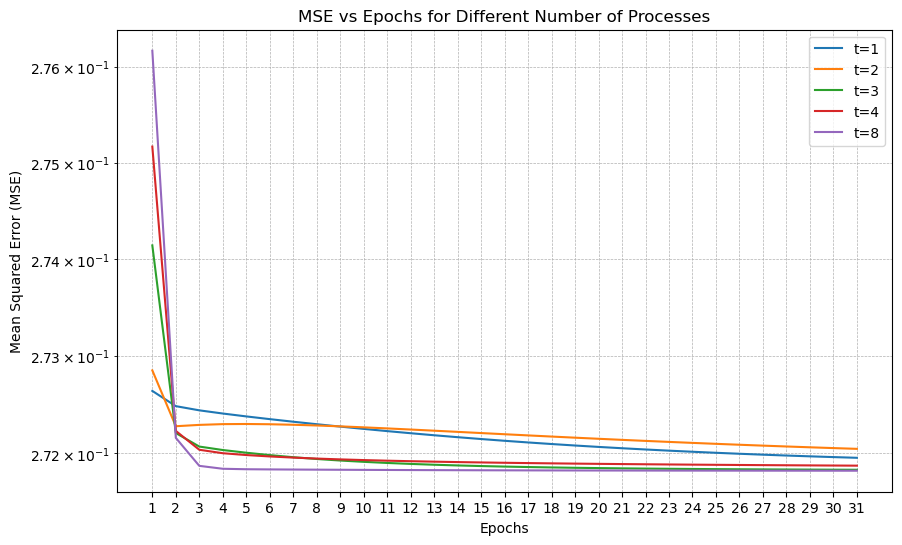

In [6]:
plot_mse_vs_epochs(X, y, 4, 0.001, 300000)